In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fft import fft, ifft, fftfreq
import matplotlib
import bagpy
from bagpy import bagreader
import pandas as pd
from scipy.signal import argrelextrema
from matplotlib.colors import LogNorm
from matplotlib import colors
import seaborn as sns 
import math
from scipy import signal

matplotlib.rcParams.update({'font.size': 22})

In [82]:
# constants
c_0 = 3e8 # speed of light
microsteps = 800 # steps/rev
pitch = 5 # mm/rev
stepspermm = microsteps/pitch


# FMCW parameters
size_SAR_x = 400 # mm
size_SAR_y = 400 # mm

dy_sampling = 1 # mm
dx_motion_step = 1 # mm
num_x = size_SAR_x/dx_motion_step #
num_y = size_SAR_y/dy_sampling #
n_frms = int(1.30 * num_x * num_y)

v_testbed = 20.0 # mm/s
dt = dy_sampling/v_testbed # second

dCfg        =   {
                    "fStrt"     :   76e9,
                    "fStop"     :   78e9,
                    "TRampUp"   :   64e-6,
                    "TRampDo"   :   32e-6,
                    "TInt"      :   dt,
                    "N"         :   256,
                    "NrFrms"    :   n_frms,
                    "IniTim"    :   1000e-3,
                    "IniEve"    :   0
                }
n_ch = 1

file_exp = "42"
# output folder
#folder_output = '/home/qiwen/Github/UA_SAR/code/Analysis/RDA_2D_test_Feb/exp%s/'%file_exp
#folder_output = '/home/qiwen/Github/UA_SAR/code/Analysis/RDA_investigations/t_%ds/exp%s/'%(t_sar_actual,file_exp)
#folder_output = '/home/wq3939390/SAR_project/code/Analysis/Motion_Emulation/1Ddata/exp%s/'%file_exp
#folder_output = '/home/qiwen/Github/SAR_project/code/Analysis/motion_error_Sep2022/exp%s/'%file_exp
folder_output = '/home/wq3939390/SAR_project/code/Analysis/motion_error_Sep2022/exp%s/'%file_exp

In [83]:
path = '/home/wq3939390/SAR_project/code/Radarbook/Python/PyAppNotes/output/20221019/'
#path = '/home/qiwen/Github/SAR_project/data/20220302/'
data_R = np.loadtxt(path + "R_exp%s.txt"%file_exp, delimiter = ',')

# plot at all range
'''
for idx_maxP in range(1,8):
    for ch in range(1,3):
        df_grid = pd.read_pickle(folder_output+"2D_grid_mapped_R0_idx%d.pkl"%idx_maxP)
        fig = plt.figure(figsize=(20,20))
        table = df_grid.pivot('y [mm]', 'x [mm]', 'radar_ch%d'%ch)
        ax = sns.heatmap(abs(table),cbar_kws={'label': 'Radar'}, norm=LogNorm(1e2,5e4)) #log scale
        #ax = sns.heatmap(abs(table),cbar_kws={'label': 'Radar'}, vmin=1,vmax=5e4)
        #ax.invert_yaxis()
        plt.title("Radar Tx1-Rx%d raw data @ R =%.3f m"%(ch,data_R[idx_maxP]))
        fig.savefig(folder_output+'radar_raw_data/grid_radar_ch%d_raw_data_R_idx%d.jpg'%(ch,idx_maxP))
        #plt.show()
'''

'\nfor idx_maxP in range(1,8):\n    for ch in range(1,3):\n        df_grid = pd.read_pickle(folder_output+"2D_grid_mapped_R0_idx%d.pkl"%idx_maxP)\n        fig = plt.figure(figsize=(20,20))\n        table = df_grid.pivot(\'y [mm]\', \'x [mm]\', \'radar_ch%d\'%ch)\n        ax = sns.heatmap(abs(table),cbar_kws={\'label\': \'Radar\'}, norm=LogNorm(1e2,5e4)) #log scale\n        #ax = sns.heatmap(abs(table),cbar_kws={\'label\': \'Radar\'}, vmin=1,vmax=5e4)\n        #ax.invert_yaxis()\n        plt.title("Radar Tx1-Rx%d raw data @ R =%.3f m"%(ch,data_R[idx_maxP]))\n        fig.savefig(folder_output+\'radar_raw_data/grid_radar_ch%d_raw_data_R_idx%d.jpg\'%(ch,idx_maxP))\n        #plt.show()\n'

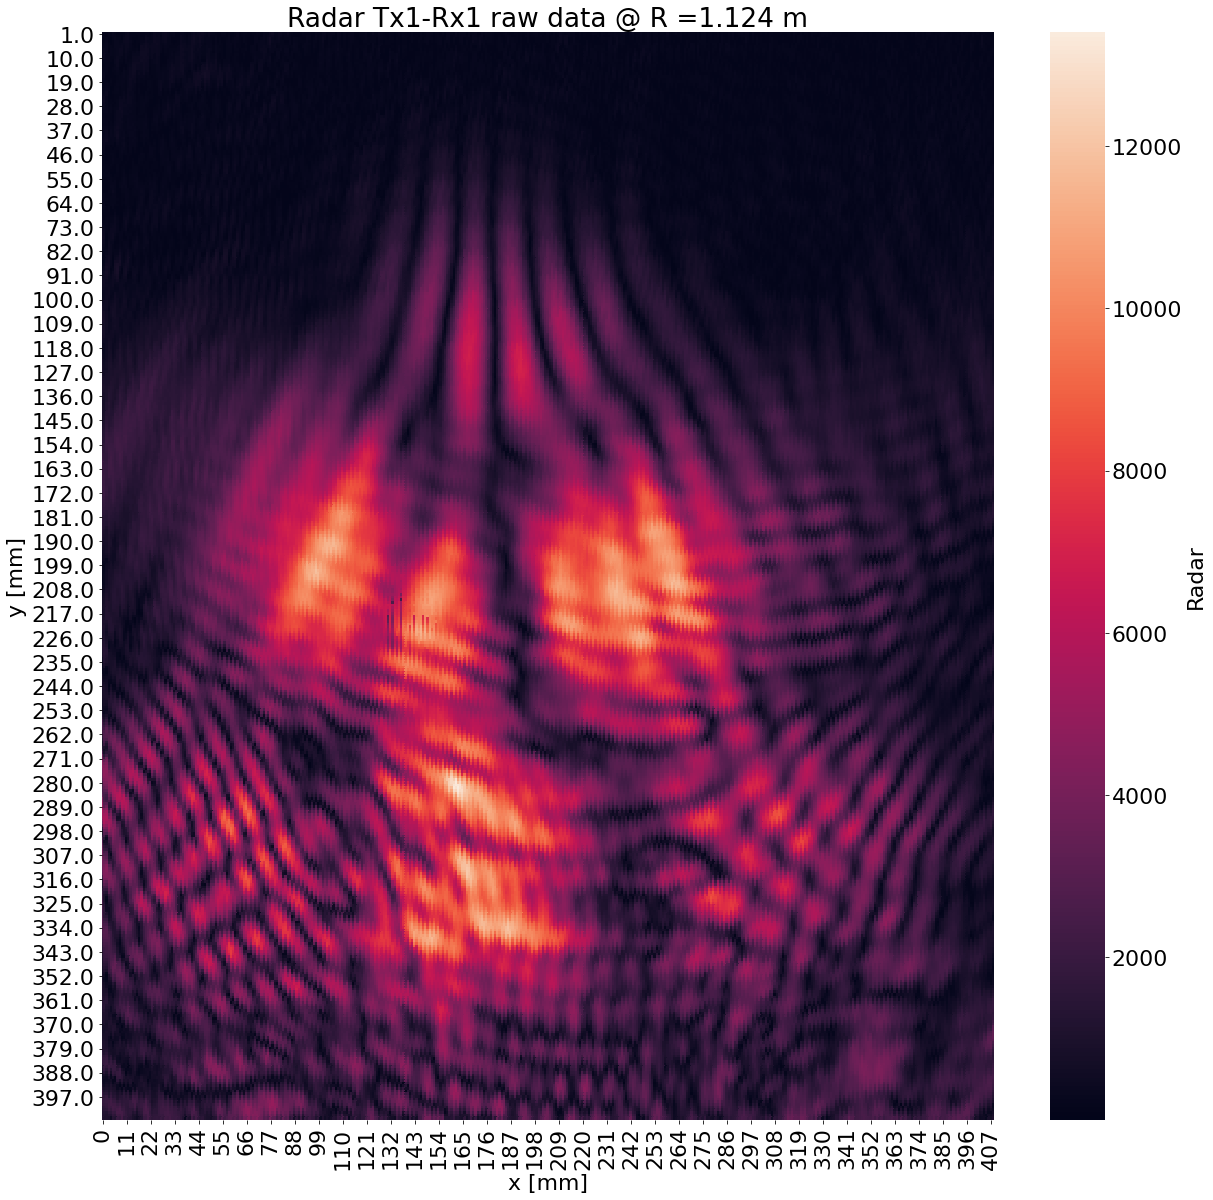

In [144]:
# data to work on
mu_dist = 0 # motion error mu
ch = 1
idx_maxP = 4

# load data
df_grid = pd.read_pickle(folder_output+"MotionError_mu_%d/2D_grid_mapped_R0_idx%d.pkl"%(mu_dist, idx_maxP))
fig = plt.figure(figsize=(20,20))
table = df_grid.pivot('y [mm]', 'x [mm]', 'radar_ch%d'%ch)

# plot the data
ax = sns.heatmap(abs(table),cbar_kws={'label': 'Radar'}) #log scale
plt.title("Radar Tx1-Rx%d raw data @ R =%.3f m"%(ch,data_R[idx_maxP]))
fig.savefig(folder_output+'MotionError_mu_%d/raw_data_ch%d_R =%.3f.jpg'%(mu_dist,ch,data_R[idx_maxP]))

In [145]:
# emulate motion
v_emulated = 10*1e-3 # m/s
delta_x = abs(df_grid['x [mm]'][df_grid['y [mm]']==1].iloc[1] - df_grid['x [mm]'][df_grid['y [mm]']==1].iloc[0]) # mm
delta_y = abs(df_grid['y [mm]'][df_grid['x [mm]']==1].iloc[1] - df_grid['y [mm]'][df_grid['x [mm]']==1].iloc[0]) # mm

timestep_slow_x = 1e-3*delta_x/v_emulated # second
timestep_slow_y = 1e-3*delta_y/v_emulated # second

m_y = df_grid[df_grid['x [mm]']==1].shape[0]
m_x = df_grid[df_grid['y [mm]']==1].shape[0]

print(m_x,m_y)

freq_slow_x = fftfreq(m_x, timestep_slow_x)
freq_slow_y = fftfreq(m_y, timestep_slow_y)

eta_x = np.arange(0,math.floor(100*timestep_slow_x*m_x)/100,timestep_slow_x)
eta_y = np.arange(0,math.floor(100*timestep_slow_y*m_y)/100,timestep_slow_y)
print(eta_x.shape)
print(eta_y.shape)

# mapping to X
wavelength = c_0 / ((dCfg['fStop'] + dCfg['fStrt'])/2) # in meter
idx_R0 = idx_maxP
R0 = data_R[idx_R0] # in meter # in meter
print(R0)

X = 1e3 * np.fft.fftshift(freq_slow_x) * wavelength * R0 / 2 / v_emulated # mm
Y = 1e3 * np.fft.fftshift(freq_slow_y) * wavelength * R0 / 2 / v_emulated # mm

409 405
(409,)
(405,)
1.1242217175000004


In [146]:
#w_x = signal.windows.chebwin(m_x, at=50)
#w_y = signal.windows.chebwin(m_y, at=100)

w_x = signal.windows.hamming(m_x)
w_y = signal.windows.hamming(m_y)

table_window = np.multiply(table,w_x)
#table_window = np.transpose(np.multiply(table_window.T,w_y))


Range Doppler Algorithm

In [147]:
data_raw = np.array(table) # no windowing
#data_raw = np.array(table_window) # with windowing

print(data_raw.shape)


# reference signal
Ka = 2*v_emulated**2/(wavelength*R0)
print(v_emulated,wavelength, R0, Ka)

#Azimuth Reference Signal
smb0_x=np.exp(1j*np.pi*Ka*eta_x*(np.max(eta_x)-eta_x));
smb0_y=np.exp(1j*np.pi*Ka*eta_y*(np.max(eta_y)-eta_y));

#Azimuth Matched Filter Spectrum
fsmb0_x = np.fft.fft(np.conj(smb0_x[::-1]))
fsmb0_y = np.fft.fft(np.conj(smb0_y[::-1]))

# Azimuth compression in frequency domain
# x first then y
result_fft_x = np.fft.fft(data_raw,axis=1) # FFT of data
fsac_x = np.multiply(np.conjugate(fsmb0_x).reshape(m_x,1),result_fft_x.T)
sac_x=ifft(fsac_x,axis=0).T
result_2ndfft_x = np.fft.fft(sac_x,axis=0)
fsac_1 = np.multiply(np.conjugate(fsmb0_y).reshape(m_y,1),result_2ndfft_x)
sac_1=ifft(fsac_1,axis=0)


# y first then x
result_fft_y = np.fft.fft(data_raw,axis=0) # FFT of data
fsac_y = np.multiply(np.conjugate(fsmb0_y).reshape(m_y,1),result_fft_y)
sac_y=ifft(fsac_y,axis=0)
result_2ndfft_y = np.fft.fft(sac_y,axis=1)
fsac_2 = np.multiply(np.conjugate(fsmb0_x).reshape(m_x,1),result_2ndfft_y.T)
sac_2=ifft(fsac_2.T,axis=1)


(405, 409)
0.01 0.003896103896103896 1.1242217175000004 0.04566121836490258


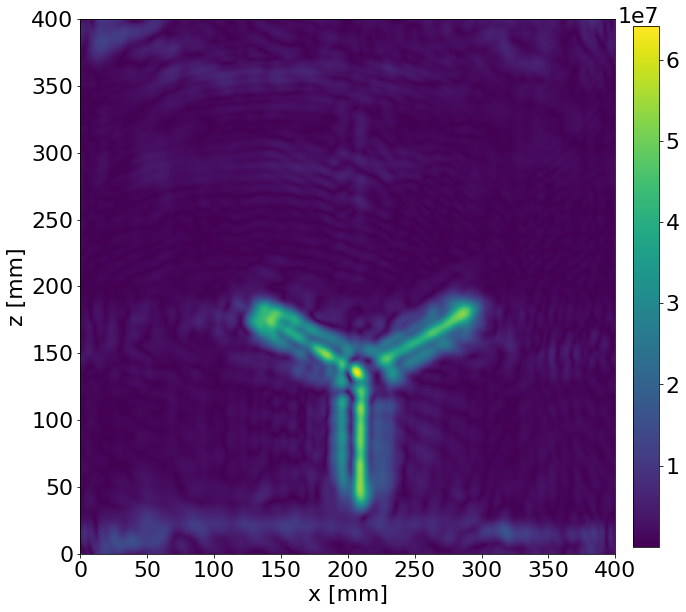

In [148]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
#fig.suptitle('Ch:%d'%(ch))

img = abs(np.fft.fftshift(np.fft.fftshift(sac_1,axes=(1,)),axes=(0,)))
np.savetxt(folder_output+'MotionError_mu_%d/final_result_RDA_ch%d_no_window.csv'%(mu_dist,ch), img, delimiter=',') 
#z2_plot = plt.imshow(img,norm=LogNorm(vmin=np.max(img)/10, vmax=1.2e8))
z2_plot = plt.imshow(img,vmin=np.min(img), vmax=np.max(img),extent=(0,400,0,400))


ax.set_xlabel('x [mm]')
ax.set_ylabel('z [mm]')
plt.colorbar(z2_plot,ax=ax,fraction=0.045,pad=0.03)
    
fig.tight_layout(rect=[0, 0, 1, 1])
#np.savetxt('ch2_RDA_image.csv',img,delimiter=',')
plt.savefig(folder_output+'MotionError_mu_%d/final_result_RDA_no_window_mu%d.jpg'%(mu_dist,mu_dist))
#fig.savefig(folder_output+'/final_result_RDA_exp%s_ch%d_hamming_window.jpg'%(file_exp,ch))
#fig.savefig(folder_output+'/final_result_RDA_exp%s_ch%d_no_window_R =%.3f.jpg'%(file_exp,ch,data_R[idx_maxP]))

plt.show()

In [149]:
# Integrate over distance R
ch = 2

img = np.zeros((m_y,m_x))

for i in range(1,8):
    print('R =%.3f.jpg'%(data_R[i]))
    # data to work on
    idx_maxP = i
    df_grid = pd.read_pickle(folder_output+"2D_grid_mapped_R0_idx%d.pkl"%idx_maxP)
    table = df_grid.pivot('y [mm]', 'x [mm]', 'radar_ch%d'%ch)
    
    
    data_raw = np.array(table)
    #data_raw = np.array(table_window)

    # reference signal
    Ka = 2*v_emulated**2/(wavelength*R0)
    print(v_emulated,wavelength, R0, Ka)

    #Azimuth Reference Signal
    smb0_x=np.exp(1j*np.pi*Ka*eta_x*(np.max(eta_x)-eta_x));
    smb0_y=np.exp(1j*np.pi*Ka*eta_y*(np.max(eta_y)-eta_y));

    #Azimuth Matched Filter Spectrum
    fsmb0_x = np.fft.fft(np.conj(smb0_x[::-1]))
    fsmb0_y = np.fft.fft(np.conj(smb0_y[::-1]))

    # Azimuth compression in frequency domain
    # x first then y
    result_fft_x = np.fft.fft(data_raw,axis=1) # FFT of data
    fsac_x = np.multiply(np.conjugate(fsmb0_x).reshape(m_x,1),result_fft_x.T)
    sac_x=ifft(fsac_x,axis=0).T
    result_2ndfft_x = np.fft.fft(sac_x,axis=0)
    fsac_1 = np.multiply(np.conjugate(fsmb0_y).reshape(m_y,1),result_2ndfft_x)
    sac_1=ifft(fsac_1,axis=0)


    # y first then x
    result_fft_y = np.fft.fft(data_raw,axis=0) # FFT of data
    fsac_y = np.multiply(np.conjugate(fsmb0_y).reshape(m_y,1),result_fft_y)
    sac_y=ifft(fsac_y,axis=0)
    result_2ndfft_y = np.fft.fft(sac_y,axis=1)
    fsac_2 = np.multiply(np.conjugate(fsmb0_x).reshape(m_x,1),result_2ndfft_y.T)
    sac_2=ifft(fsac_2.T,axis=1)
    
    # image
    img_i = abs(np.fft.fftshift(np.fft.fftshift(sac_1,axes=(1,)),axes=(0,)))
    img = img+img_i
    

fig, ax = plt.subplots(1,1, figsize=(20,20))
fig.suptitle('Ch:%d, integrating over R = [0.597,1.045] m'%(ch))

#z2_plot = plt.imshow(img,norm=LogNorm(vmin=np.max(img)/10, vmax=1.2e8))
z2_plot = plt.imshow(img,vmin=np.min(img), vmax=np.max(img))


ax.set_xlabel('X / m')
ax.set_ylabel('Y / m')
plt.colorbar(z2_plot,ax=ax)

fig.tight_layout(rect=[0, 0, 1, 0.95])
#fig.savefig(folder_output+'/final_result_RDA_exp%s_ch%d_dBscale10_cheby_window_100dB.jpg'%(file_exp,ch))
#fig.savefig(folder_output+'/final_result_RDA_exp%s_ch%d_no_window_R =%.3f.jpg'%(file_exp,ch,data_R[idx_maxP]))
#fig.savefig(folder_output+'/final_result_RDA_exp%s_ch%d_no_window_integrateR.jpg'%(file_exp,ch))

plt.show()

R =0.899.jpg


FileNotFoundError: [Errno 2] No such file or directory: '/home/wq3939390/SAR_project/code/Analysis/motion_error_Sep2022/exp42/2D_grid_mapped_R0_idx1.pkl'